In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [10]:
#Code for creating data frame of testing data
data = pd.read_csv('requests.csv')
data.columns = ['timestamp', 'userID', 'sessionID', 'expiring', 'URL']
print(data)

            timestamp      userID                              sessionID  \
0       1676373343936   user-1003   c85cbd00-d2fc-4cda-9f5c-66616847d851   
1       1676373344344   user-1005   a0038f81-b46a-4f26-a7ea-2791d53404fb   
2       1676373344456   user-1003   c85cbd00-d2fc-4cda-9f5c-66616847d851   
3       1676373344912     user-65   fd48a9f9-67f4-4185-9bcc-a76b7139401c   
4       1676373345020   user-1005   a0038f81-b46a-4f26-a7ea-2791d53404fb   
...               ...         ...                                    ...   
263206  1676444990852    user-629   2a43fe7f-d300-470d-9523-d362b70b37d3   
263207  1676444991104    user-629   2a43fe7f-d300-470d-9523-d362b70b37d3   
263208  1676444991342    user-629   2a43fe7f-d300-470d-9523-d362b70b37d3   
263209  1676444991375   user-1005   0e84ab80-bfa4-402b-9ae0-6397441e91d6   
263210  1676444992110   user-1005   0e84ab80-bfa4-402b-9ae0-6397441e91d6   

             expiring                            URL  
0       1676373495816           

In [12]:
users = list(data['userID'])
allUsers = data.set_index(['userID']).rename_axis(None)
allUsers = allUsers.drop(columns=['timestamp', 'sessionID', 'expiring'])
df = allUsers.groupby( level=0).agg(','.join)
df

,URL
user-10,"/login, /searchUsers?page=0, /profile/372, /c..."
user-100,"/login, /searchUsers?page=0, /profile/716, /p..."
user-1000,"/login, /searchUsers?page=0, /profile/626, /c..."
user-1001,"/login, /searchUsers?page=0, /profile/117, /p..."
user-1002,"/login, /searchUsers?page=0, /profile/162, /c..."
...,...
user-995,"/login, /searchUsers?page=0, /profile/337, /p..."
user-996,"/login, /searchUsers?page=0, /profile/642, /p..."
user-997,"/login, /searchUsers?page=0, /profile/760, /c..."
user-998,"/login, /searchUsers?page=0, /profile/944, /p..."


In [ ]:
request_logs = df['URL']

cleaned_logs = []

for i in range(0, len(request_logs)):
    sequence = re.sub('[^a-zA-Z]', ' ', request_logs[i])
    sequence = sequence.lower()
    cleaned_logs.append(sequence)

# 5 and 6: spammers, 7: data scraper
print(cleaned_logs[7])

In [14]:
df['request_logs'] = cleaned_logs
df = df.drop('URL', axis=1)
df

,request_logs
user-10,login searchusers page profile c...
user-100,login searchusers page profile p...
user-1000,login searchusers page profile c...
user-1001,login searchusers page profile p...
user-1002,login searchusers page profile c...
...,...
user-995,login searchusers page profile p...
user-996,login searchusers page profile p...
user-997,login searchusers page profile c...
user-998,login searchusers page profile p...


In [15]:
#Using the tfidf-vectorizer
tfidf_vect = TfidfVectorizer()
vect_logs = tfidf_vect.fit_transform(df['request_logs'])

print(vect_logs.todense())

[[0.04185434 0.28270935 0.02389254 ... 0.26359964 0.28270935 0.02389254]
 [0.         0.25720906 0.         ... 0.17789072 0.25720906 0.        ]
 [0.0773957  0.26138851 0.04418132 ... 0.19149427 0.26138851 0.04418132]
 ...
 [0.02328439 0.16776186 0.02658378 ... 0.20949376 0.16776186 0.02658378]
 [0.         0.25652834 0.         ... 0.17084881 0.25652834 0.        ]
 [0.09897283 0.356545   0.         ... 0.1780952  0.356545   0.        ]]


In [38]:
#Just some code to see what we got :)
vector_tfidfvectorizer=vect_logs[1] 
df2 = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=tfidf_vect.get_feature_names_out(), columns=["tfidf"])
df2.sort_values(by=["tfidf"], ascending=False)

,tfidf
conversation,0.674041
profile,0.455515
markasread,0.337020
chat,0.257209
send,0.257209
page,0.217422
searchusers,0.177891
login,0.098828
inbox,0.043025
report,0.025107


In [17]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

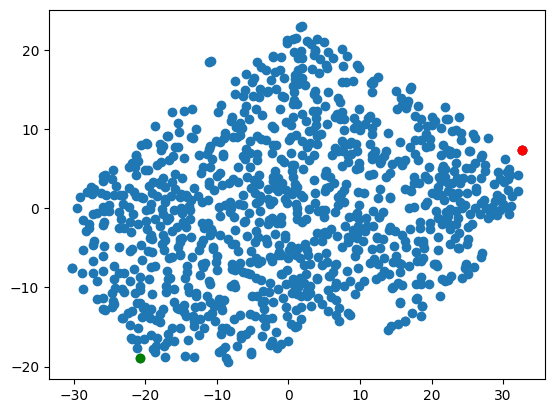

In [18]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

In [32]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1004, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.014151,-0.056579,0.032928,-0.023269,0.055481,-0.034205,-0.040538,0.025775,-0.016518,0.009518,1.518194e-16,-3.121390e-17,8.674852e-17,2.548482e-17,5.323735e-18
1,-0.004119,0.024946,-0.147911,-0.022661,0.028510,0.034089,-0.014530,0.004799,0.003663,-0.007788,3.815686e-17,4.455436e-17,-1.845179e-17,6.953339e-18,-6.783906e-19
2,-0.014892,-0.116458,-0.007735,0.021352,-0.046803,-0.034033,0.011968,0.011323,-0.003120,0.009117,6.519605e-17,8.386678e-18,2.377981e-17,8.514586e-17,-1.888343e-17
3,0.053916,0.163665,-0.006286,0.058890,-0.023201,-0.003443,-0.069031,0.003830,0.044711,0.003305,6.282868e-17,-7.387246e-17,-5.550870e-17,3.040108e-17,7.210448e-17
4,-0.117871,0.056486,-0.085556,-0.028776,0.044079,0.009919,-0.032389,0.033688,0.008695,0.033079,-7.070084e-17,-7.645424e-18,-2.397089e-18,1.305681e-18,-2.548306e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.003835,0.099379,0.097485,0.005731,-0.050682,0.024302,-0.019628,0.004157,-0.008210,-0.023072,1.304895e-16,2.411514e-18,-2.274852e-21,-2.891844e-18,1.595905e-19
1000,0.065047,0.050680,-0.043768,0.016372,-0.001074,-0.001450,0.013162,0.007790,-0.017865,-0.020936,1.146830e-16,1.050317e-18,-4.386072e-18,7.993606e-19,-9.338723e-19
1001,-0.146306,-0.000804,-0.094498,-0.031923,-0.004844,0.033087,0.017118,-0.003498,0.002426,-0.018177,1.004649e-16,3.246649e-19,5.332306e-19,4.944381e-19,1.084607e-18
1002,-0.020214,-0.117290,-0.037662,0.069434,-0.017167,0.054558,0.004377,-0.023142,-0.014244,0.004660,1.068999e-16,2.076727e-18,-3.954988e-19,1.899252e-18,-1.176349e-19


In [36]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [0.01488, 0.00659, 0.0065, 0.0027, 0.00165, 0.00096, 0.00072, 0.00067, 0.00064, 0.00044, 0.0, 0.0, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [4.16085399e-01 1.84349822e-01 1.81923581e-01 7.55255767e-02
 4.62256577e-02 2.67749579e-02 2.01896368e-02 1.87541698e-02
 1.79152153e-02 1.22559840e-02 3.69365857e-31 1.53002736e-33
 7.48972755e-34 3.08356030e-34 2.23440678e-34]
None


Following code just serves as a way to experiment using sequence of numbers. Could we use tfidf for vectorizing data?

In [94]:
#Function to create a sequence of numbers. Approx. 10% of the sequences will consist of duplicates of the same number
import random

def create_sequence(arr, randVal):
    if (randVal < 1):
        val = random.randint(1,9)
        for i in range (50):
            arr.append(val)
    else:    
        for i in range (0, 50):
            arr.append(random.randint(1,9))
    return arr    

In [95]:
#Function to give a sequence a score depending on number of consecutive duplicates
def sequence_evaluation(df):
    arr = []
    for i in range (0, df.shape[0]):
        data = df.iloc[i].to_list()
        score = 0
        lr = 0.1
        val = data[0]
        for j in range (1, len(data)):
            if (data[j] == val):
                score -= lr*data[j]
                if(lr < 1):
                    lr += 1.1*lr
            else:
                score += data[j]
                val = data[j]
        arr.append(score) 
    return arr     

In [96]:
#Function that calculates length of the longest subsequence of consecutive duplicates for each sequence
from itertools import groupby

def longestConsecutive(df):
    arr = []
    for i in range (0, df.shape[0]):
        longest_streak = len(max([list(group) for _, group in groupby(df.iloc[i].to_list())], key=len))
        arr.append(longest_streak)
    return arr

In [97]:
#Creation of the sequence data frame
sequence_matrix = []
for i in range (1000):
    randVal = random.randint(0,9)
    arr = []
    sequence_matrix.append(create_sequence(arr, randVal))

sequence_df = pd.DataFrame(sequence_matrix)

sequence_df['score'] = sequence_evaluation(sequence_df)
sequence_df['longestConsec'] = longestConsecutive(sequence_df.loc[:, sequence_df.columns != 'score'])
sequence_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,score,longestConsec
0,5,8,2,2,7,3,5,7,9,2,...,7,6,4,6,6,5,5,6,164.23217,2
1,2,4,3,8,6,6,4,6,9,7,...,1,8,9,6,3,7,2,9,245.33400,2
2,6,4,8,9,8,6,9,7,2,3,...,1,3,2,5,3,2,5,4,222.99400,3
3,8,8,4,6,3,6,6,6,2,7,...,5,5,8,4,9,4,5,1,109.37439,3
4,1,1,4,2,4,4,1,8,3,1,...,6,4,9,3,6,1,5,7,137.27363,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7,6,7,6,8,1,5,7,9,9,...,6,8,3,2,4,4,8,1,195.62823,4
996,1,8,5,4,9,2,6,6,7,9,...,5,3,1,3,2,2,9,5,190.36118,2
997,7,1,2,6,1,2,6,8,8,5,...,5,3,2,9,5,2,5,6,161.79741,2
998,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,-178.38710,50


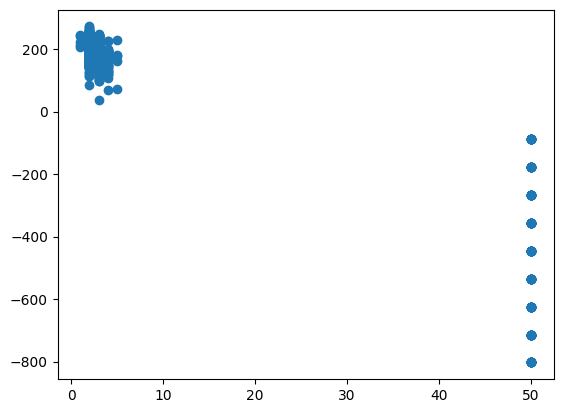

In [102]:
#A yanky scatter plot....
plt.scatter(sequence_df['longestConsec'], sequence_df['score'])